In [1]:
# Function to generate serpentine positions across a 1280x720 grid
def generate_serpentine_positions(num_positions=20, width=1280, height=720):
    x_step = width // 5  # 5 horizontal steps
    y_step = height // 4  # 4 vertical steps (for 20 positions -> 4 rows)

    positions = []
    pos_count = 0

    # Generate positions with serpentine pattern
    for row in range(4):  # We want 4 rows of movement
        y = row * y_step
        if row % 2 == 0:  # Left to right on even rows
            for x in range(0, width, x_step):
                if pos_count < num_positions:
                    positions.append((x, y))
                    pos_count += 1
        else:  # Right to left on odd rows
            for x in range(width - x_step, -1, -x_step):
                if pos_count < num_positions:
                    positions.append((x, y))
                    pos_count += 1

    return positions

# Generate the list of positions
serpentine_positions = generate_serpentine_positions()
serpentine_positions

[(0, 0),
 (256, 0),
 (512, 0),
 (768, 0),
 (1024, 0),
 (1024, 180),
 (768, 180),
 (512, 180),
 (256, 180),
 (0, 180),
 (0, 360),
 (256, 360),
 (512, 360),
 (768, 360),
 (1024, 360),
 (1024, 540),
 (768, 540),
 (512, 540),
 (256, 540),
 (0, 540)]

Reading frames...
Total frames read: 200

Processing position 1/20: (0, 0)
Processing pixel time series...
Calculating Euclidean distances...
Normalizing distances...
Similarity Image - min: 0.0, max: 1.0, mean: 0.4452079236507416
Saved similarity_image_0_0.png for inspection.


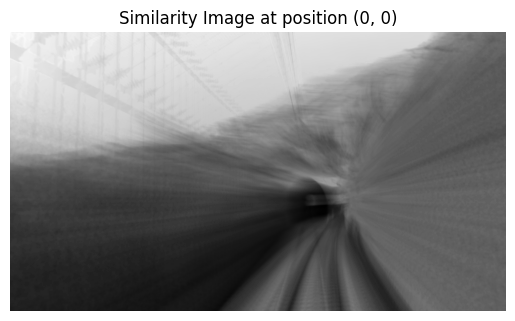

Creating threshold videos for position 1:   0%|                                                 | 0/14 [00:00<?, ?it/s]

ffmpeg command failed with error:
ffmpeg version 7.1-essentials_build-www.gyan.dev Copyright (c) 2000-2024 the FFmpeg developers
  built with gcc 14.2.0 (Rev1, Built by MSYS2 project)
  configuration: --enable-gpl --enable-version3 --enable-static --disable-w32threads --disable-autodetect --enable-fontconfig --enable-iconv --enable-gnutls --enable-libxml2 --enable-gmp --enable-bzlib --enable-lzma --enable-zlib --enable-libsrt --enable-libssh --enable-libzmq --enable-avisynth --enable-sdl2 --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libaom --enable-libopenjpeg --enable-libvpx --enable-mediafoundation --enable-libass --enable-libfreetype --enable-libfribidi --enable-libharfbuzz --enable-libvidstab --enable-libvmaf --enable-libzimg --enable-amf --enable-cuda-llvm --enable-cuvid --enable-dxva2 --enable-d3d11va --enable-d3d12va --enable-ffnvcodec --enable-libvpl --enable-nvdec --enable-nvenc --enable-vaapi --enable-libgme --enable-libopenmpt --enable-libopen

CalledProcessError: Command '['ffmpeg', '-y', '-i', 'temp_input_video.mp4', '-i', 'mask.png', '-i', 'circle.png', '-filter_complex', "[0][1]overlay=shortest=1[tmp1];[tmp1][2]overlay=shortest=1,drawtext=text='similarity threshold\\: 0.99':x=(w-tw)-50:50:fontcolor=black:fontsize=24,drawtext=text='white pixels inside circle\\: 5':x=(w-tw)-50:80:fontcolor=black:fontsize=24,drawtext=text='percentage inside circle\\: 100%':x=(w-tw)-50:110:fontcolor=black:fontsize=24,drawtext=text='pixels\\: 5':x=(w-tw)-50:140:fontcolor=black:fontsize=24", '-codec:a', 'copy', 'videos\\euclidean_annotated_video_threshold_0.99_pos_1.mp4']' returned non-zero exit status 4294967274.

In [3]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

def read_frames(input_video_path, num_frames=200, verbose=False):
    # Open the input video
    cap = cv2.VideoCapture(input_video_path)

    # Check if video opened successfully
    if not cap.isOpened():
        if verbose:
            print("Error: Could not open video.")
        return None, None, None

    # Get video properties
    fps = cap.get(cv2.CAP_PROP_FPS)
    ret, frame = cap.read()
    if not ret:
        if verbose:
            print("Failed to read the first frame of the video.")
        cap.release()
        return None, None, None

    height, width, channels = frame.shape
    frame_size = (height, width, channels)

    # Initialize array to store frames
    frames_array = []

    if verbose:
        print("Reading frames...")

    # Read the specified number of frames
    frame_count = 0
    while frame_count < num_frames:
        if frame is None:
            if verbose:
                print(f"Reached end of video at frame {frame_count}.")
            break
        frames_array.append(frame)
        ret, frame = cap.read()
        frame_count += 1

    cap.release()
    num_frames = len(frames_array)

    if verbose:
        print(f"Total frames read: {num_frames}")

    # Convert frames list to numpy array
    frames_array = np.array(frames_array, dtype=np.uint8)  # Shape: (num_frames, height, width, 3)

    return frames_array, fps, frame_size

def write_frames_to_video(frames_array, output_video_path, fps):
    height, width = frames_array.shape[1:3]
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    for frame in frames_array:
        out.write(frame)
    out.release()

def compute_similarities(frames_array, position, verbose=False):
    # Extract dimensions
    num_frames, height, width, channels = frames_array.shape

    # Get the specified position
    center_x, center_y = position

    # Reshape frames to (height * width, num_frames * channels)
    if verbose:
        print("Processing pixel time series...")
    frames_reshaped = frames_array.transpose(1, 2, 0, 3).reshape(height * width, num_frames * channels)

    # Get the time series of the specified pixel
    center_index = center_y * width + center_x
    center_pixel_vector = frames_reshaped[center_index, :]

    # Compute Euclidean distances
    if verbose:
        print("Calculating Euclidean distances...")
    diffs = frames_reshaped.astype(np.float32) - center_pixel_vector.astype(np.float32)
    distances = np.linalg.norm(diffs, axis=1)

    # Normalize distances to get similarity (0 to 1)
    if verbose:
        print("Normalizing distances...")
    max_distance = distances.max()
    if max_distance == 0:
        if verbose:
            print("Max distance is zero. All pixels are identical to the specified pixel.")
        similarity = np.ones_like(distances)
    else:
        similarity = 1 - (distances / max_distance)

    # Reshape similarity back to image shape
    similarity_image = similarity.reshape(height, width)

    if verbose:
        print(f"Similarity Image - min: {similarity_image.min()}, max: {similarity_image.max()}, mean: {similarity_image.mean()}")

    # Optionally, save the similarity image for inspection
    similarity_visual = (similarity_image * 255).astype(np.uint8)
    cv2.imwrite(f'similarity_image_{center_x}_{center_y}.png', similarity_visual)
    if verbose:
        print(f"Saved similarity_image_{center_x}_{center_y}.png for inspection.")

    return similarity_image

def process_frames_for_threshold(frames_array, similarity_image, threshold, output_video_path, fps, frame_size, center_coords, dot_size=10):
    import subprocess
    import shutil
    from PIL import Image, ImageDraw

    height, width, channels = frame_size
    center_x, center_y = center_coords
    num_frames = frames_array.shape[0]

    # Create mask for pixels based on threshold
    mask = (similarity_image >= threshold).astype(np.uint8)  # Shape: (height, width)
    num_masked_pixels = np.sum(mask)

    if num_masked_pixels == 0:
        print(f"No pixels found with similarity >= {threshold}. Skipping overlay.")
        # Proceed without overlay
        # Copy temp_input_video.mp4 to output_video_path
        shutil.copyfile('temp_input_video.mp4', output_video_path)
        return
    else:
        # Create circle image with transparency
        circle_image = Image.new('RGBA', (width, height), (0, 0, 0, 0))
        draw = ImageDraw.Draw(circle_image)
        draw.ellipse(
            (center_x - dot_size, center_y - dot_size, center_x + dot_size, center_y + dot_size),
            outline=(255, 0, 0, 255)
        )
        circle_image_path = 'circle.png'
        circle_image.save(circle_image_path)

        # Generate mask image with transparency
        mask_rgba = np.zeros((height, width, 4), dtype=np.uint8)
        mask_rgba[:, :, 0:3] = 255  # White color
        mask_rgba[:, :, 3] = mask * 255  # Alpha channel
        mask_image_path = 'mask.png'
        mask_pil = Image.fromarray(mask_rgba, 'RGBA')
        mask_pil.save(mask_image_path)

        # Format percentage_inside
        num_white_pixels = np.sum(mask == 1)
        circle_mask = np.zeros((height, width), dtype=np.uint8)
        cv2.circle(circle_mask, (center_x, center_y), dot_size, 1, thickness=-1)
        num_white_inside = np.sum((mask == 1) & (circle_mask == 1))
        percentage_inside = (num_white_inside / num_white_pixels) * 100 if num_white_pixels > 0 else 0

        # Format percentage string
        if percentage_inside >= 100:
            percentage_inside_str = f"{percentage_inside:.0f}"
        elif percentage_inside >= 10:
            percentage_inside_str = f"{percentage_inside:.1f}"
        else:
            percentage_inside_str = f"{percentage_inside:.2f}"

        # Escape colons and single quotes in text
        text1 = f"similarity threshold: {threshold:.2f}"
        text2 = f"white pixels inside circle: {num_white_inside}"
        text3 = f"percentage inside circle: {percentage_inside_str}%"
        text4 = f"pixels: {num_white_pixels}"

        # Escape special characters
        def escape_text(text):
            return text.replace('\\', '\\\\').replace(':', '\\:').replace("'", "\\'")
        text1_escaped = escape_text(text1.lower())
        text2_escaped = escape_text(text2)
        text3_escaped = escape_text(text3)
        text4_escaped = escape_text(text4)

        # Positions for text
        position_text1 = f"(w-tw)-50:50"
        position_text2 = f"(w-tw)-50:80"
        position_text3 = f"(w-tw)-50:110"
        position_text4 = f"(w-tw)-50:140"

        # Build drawtext filters
        drawtext1 = f",drawtext=text='{text1_escaped}':x={position_text1}:fontcolor=black:fontsize=24"
        drawtext2 = f",drawtext=text='{text2_escaped}':x={position_text2}:fontcolor=black:fontsize=24"
        drawtext3 = f",drawtext=text='{text3_escaped}':x={position_text3}:fontcolor=black:fontsize=24"
        drawtext4 = f",drawtext=text='{text4_escaped}':x={position_text4}:fontcolor=black:fontsize=24"

        # Build the filter_complex
        filter_complex = (
            f"[0][1]overlay=shortest=1[tmp1];"
            f"[tmp1][2]overlay=shortest=1"
            f"{drawtext1}{drawtext2}{drawtext3}{drawtext4}"
        )

        # Build the ffmpeg command
        ffmpeg_cmd = [
            'ffmpeg',
            '-y',
            '-i', 'temp_input_video.mp4',
            '-i', mask_image_path,
            '-i', circle_image_path,
            '-filter_complex', filter_complex,
            '-codec:a', 'copy',  # Copy the audio stream directly (if any)
            output_video_path
        ]

        # Run the ffmpeg command
        try:
            subprocess.run(ffmpeg_cmd, check=True, stderr=subprocess.PIPE, universal_newlines=True)
        except subprocess.CalledProcessError as e:
            print(f"ffmpeg command failed with error:\n{e.stderr}")
            raise

def main():
    input_video_path = 'cab_ride_trimmed.mkv'
    output_dir = 'videos'
    num_frames = 200
    verbose = True  # Set to True for detailed logs

    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        print(f"Created output directory at '{output_dir}'.")

    # Read frames once
    frames_array, fps, frame_size = read_frames(input_video_path, num_frames=num_frames, verbose=verbose)

    if frames_array is None:
        print("Failed to read frames.")
        return

    height, width, channels = frame_size

    # Write frames_array to temp_input_video.mp4
    write_frames_to_video(frames_array, 'temp_input_video.mp4', fps)

    # Generate positions (assuming generate_serpentine_positions is defined)
    num_positions = 20
    positions = generate_serpentine_positions(num_positions, width, height)

    # For each position, compute similarities and create videos
    for pos_idx, position in enumerate(positions):
        print(f"\nProcessing position {pos_idx+1}/{num_positions}: {position}")
        similarity_image = compute_similarities(frames_array, position, verbose=verbose)

        # Visualize the similarity image
        plt.imshow((similarity_image * 255).astype(np.uint8), cmap='gray')
        plt.title(f'Similarity Image at position {position}')
        plt.axis('off')  # Hide the axes
        plt.show()

        # Create multiple videos for different thresholds
        threshold_values = [0.99, 0.98, 0.95, 0.9, 0.85, 0.8, 0.75, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

        for idx, threshold in enumerate(tqdm(threshold_values, desc=f"Creating threshold videos for position {pos_idx+1}")):
            output_path = os.path.join(output_dir, f'euclidean_annotated_video_threshold_{threshold:.2f}_pos_{pos_idx+1}.mp4')
            current_dot_size = 10  # Fixed dot size of 10
            process_frames_for_threshold(
                frames_array, similarity_image, threshold, output_path, fps, frame_size, position, dot_size=current_dot_size)

        # Stitch all videos together for this position
        print(f"Stitching videos together for position {pos_idx+1}...")
        output_combined_path = os.path.join(output_dir, f'combined_thresholds_video_pos_{pos_idx+1:03d}.mp4')
        video_pattern = os.path.join(output_dir, f'euclidean_annotated_video_threshold_*_pos_{pos_idx+1}.mp4')
        video_files = sorted(glob.glob(video_pattern))

        if not video_files:
            print("No video files found to stitch.")
            continue

        # Create the list file for ffmpeg concat demuxer
        list_file = os.path.join(output_dir, f'videos_to_concat_pos_{pos_idx+1}.txt')
        with open(list_file, 'w') as f:
            for video_file in video_files:
                f.write(f"file '{os.path.abspath(video_file)}'\n")

        # Run ffmpeg to concatenate videos
        ffmpeg_cmd = [
            'ffmpeg',
            '-y',
            '-f', 'concat',
            '-safe', '0',
            '-i', list_file,
            '-c', 'copy',
            output_combined_path
        ]

        try:
            subprocess.run(ffmpeg_cmd, check=True, stderr=subprocess.PIPE, universal_newlines=True)
        except subprocess.CalledProcessError as e:
            print(f"ffmpeg concat command failed with error:\n{e.stderr}")
            raise

        print(f"Combined video saved as {output_combined_path}.")

        # Delete the list file
        os.remove(list_file)

        # Delete the non-combined videos for this position
        print(f"Deleting non-combined videos for position {pos_idx+1}...")
        for video_file in video_files:
            try:
                os.remove(video_file)
                print(f"Deleted {video_file}")
            except OSError as e:
                print(f"Error: Could not delete {video_file}. {e}")

    # Clean up temporary files
    if os.path.exists('temp_input_video.mp4'):
        os.remove('temp_input_video.mp4')
    if os.path.exists('mask.png'):
        os.remove('mask.png')
    if os.path.exists('circle.png'):
        os.remove('circle.png')

if __name__ == '__main__':
    main()
